In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from datetime import datetime
import scipy
import itertools
import geopandas as gpd
import xarray as xr
import regionmask
import statsmodels.api as sm
import statsmodels.formula.api as smf

Data from UEA CRU TS4.07 (1901-2022)

In [2]:
file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\cru_ts4.07.1901.2022.tmx.dat.nc"
file2 = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\cru_ts4.07.1901.2022.pre.dat.nc"

file_paths_list =[file,file2]
monthly_forecast=xr.Dataset()

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)], compat='override')

Data on conflict events from ACLED

In [3]:
file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Myanmar\ACLED_1997-01-01-2023-09-05-Myanmar.csv"
df = pd.read_csv(file)

Shapefile with administrative boundaries of Myanmar

In [4]:
path = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Myanmar\geoBoundaries-MMR-ADM1.geojson"
states_gdf = gpd.read_file(path) 

Limit the lat-lon and time

In [5]:
def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(states_gdf)

In [6]:
start_date = '1901-01-01'
end_date = '2023-12-31'

region = monthly_forecast[["pre",'tmx']].sel(
    time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

In [7]:
region_mask = regionmask.mask_3D_geopandas(states_gdf,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

temp_pre = region.where(region_mask)
states_gdf.reset_index(inplace=True)

In [8]:
temp_pre = temp_pre.groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [9]:
#plot the values of temp_pre for the first time step
temp_pre_s= temp_pre[temp_pre.time==temp_pre.time[4]]
#plot the values of temp_pre_s on the map
merged = states_gdf.merge(temp_pre_s, left_on='index', right_on='region', how='outer')

In [10]:
one_m= region["tmx"].sel(
    time=slice('1901-04-16', '1901-04-16'),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

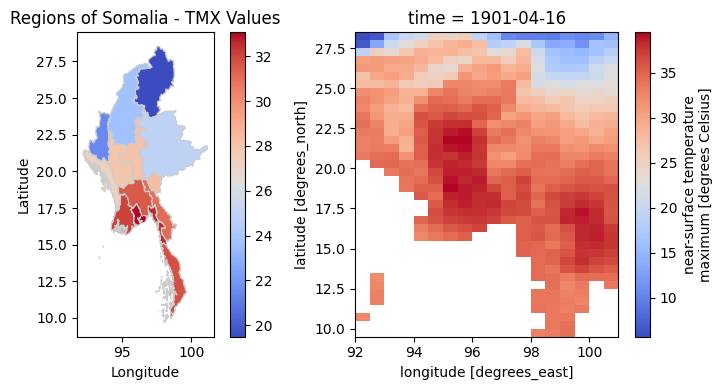

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first map - Regions of Somalia 
#the color map is the same as the one used for the second map
merged.plot(column='tmx', cmap='coolwarm', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title('Regions of Somalia - TMX Values')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot the second map - two_months_region
one_m.plot(ax=ax2, cmap='coolwarm')

plt.tight_layout()
plt.show()

In [12]:
#conf.reset_index(inplace=True)

In [13]:
#conf['admin1'].unique()

In [14]:
replacement_dict = dict(zip(states_gdf['index'], states_gdf['shapeName']))

temp_pre['admin1'] = temp_pre['region'].replace(replacement_dict)
df['admin1'] = df['admin1'].str.replace(' ', '_')
temp_pre.drop('region', axis=1, inplace=True)

# Modify event_date column to datetime

df['event_date'] = pd.to_datetime(df['event_date'])
df = df.set_index('event_date') 

In [15]:
conflict = df.groupby([pd.Grouper(freq='M'),"admin1"]).count()
conflict.reset_index(level=[0, 1], inplace=True)
conflict = conflict[['event_date','admin1','year']].rename(columns={'year': 'conflicts','event_date': 'time'})

# Aggregate the datetime objects by month
conf = conflict.groupby([pd.Grouper(key='time', freq='M'),'admin1'])['conflicts'].sum().to_frame()

In [16]:
# bago

conf.reset_index(level=[0, 1], inplace=True)

district1 = 'Bago-East'  
district2 = 'Bago-West'  

# Calculate the mean tmx and pre for the neighboring districts
sum_c = conf[(conf['admin1']==district1) | (conf['admin1']==district2)].groupby('time')['conflicts'].sum()

new_data = pd.DataFrame({ 'admin1': 'Bago', 'conflicts': sum_c}).reset_index()

# Append the new DataFrame to the original DataFrame
df3 = pd.concat([conf, new_data])

conf = df3.sort_values(by=['time', 'admin1'], ascending=[True, True]).reset_index(drop=True)
#remove rows of bago east and west

districta = 'Shan-East'  
districtb = 'Shan-North'  
districtc = 'Shan-South'  

# Calculate the mean tmx and pre for the neighboring districts
sum_c1 = conf[(conf['admin1']==districta) | (conf['admin1']==districtb) | (conf['admin1']==districtc)].groupby('time')['conflicts'].sum()

new_data1 = pd.DataFrame({ 'admin1': 'Shan', 'conflicts': sum_c1}).reset_index()

# Append the new DataFrame to the original DataFrame
df4 = pd.concat([conf, new_data1])

conf = df4.sort_values(by=['time', 'admin1'], ascending=[True, True]).reset_index(drop=True)

conf = conf[~conf['admin1'].isin(['Bago-East', 'Bago-West'])]
conf = conf[~conf['admin1'].isin(['Shan-East', 'Shan-North', 'Shan-South'])]
conf.set_index(['time', 'admin1'], inplace=True)

In [17]:
# Reindex the DataFrame with all dates and districts and fill missing values with 0

dates = conf.index.get_level_values('time').unique()
districts = conf.index.get_level_values('admin1').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts], names=['time', 'admin1'])

conflicts = conf.reindex(all_combinations, fill_value=0).reset_index()    
conflicts = conflicts.sort_values(by=['time', 'admin1'], ascending=[True, True])
conflicts.reset_index(drop=True, inplace=True)

In [18]:
temp_pre = temp_pre.sort_values(by=['time', 'admin1'], ascending=[True, True]).reset_index(drop=True)

In [19]:
# Only keep month and year in time column in temp_pre and conflicts

temp_pre['time'] = pd.to_datetime(temp_pre['time']).dt.strftime('%Y-%m-%d')
temp_pre['month'] = temp_pre['time'].str[5:7]
temp_pre['month_year'] = temp_pre['time'].str[:7]
conflicts['time'] = pd.to_datetime(conflicts['time'])
conflicts['time'] = conflicts['time'].dt.strftime('%Y-%m').values

temp_pre = temp_pre[['month_year','admin1','tmx','pre']]
temp_pre = temp_pre.rename(columns={'month_year':'time'})

In [20]:
# Split the dataframe into regions

reg=[]
for admin in temp_pre['admin1'].unique():
    a = temp_pre[temp_pre['admin1']==admin].reset_index(drop=True)
    reg.append(a)

In [21]:
# Calculate the TA (temperature anomaly), PA (precipitation anomaly) and DL (drought lenght) for each region

avg_t = avg_p = std_t = std_p = np.zeros(len(temp_pre['admin1'].unique()))

for i in range(len(temp_pre['admin1'].unique())):

    reg[i]['year'] , reg[i]['month'] = reg[i]['time'].str[:4] , reg[i]['time'].str[5:7]

    # TA
    mean_temp_i , std_temp_i  = reg[i].groupby('month')['tmx'].mean() , reg[i].groupby('month')['tmx'].std()
    reg[i]['avg_temp'] , reg[i]['std_temp']  = reg[i]['month'].map(mean_temp_i) , reg[i]['month'].map(std_temp_i)
    reg[i]['diff_t']= (reg[i]['tmx']-reg[i]['avg_temp'])/reg[i]['std_temp']
    reg[i]['TA'] = (reg[i]['diff_t'].shift(2) + reg[i]['diff_t'].shift(1) + reg[i]['diff_t'])/3

    # PA
    mean_pre_i , std_pre_i  = reg[i].groupby('month')['pre'].mean() , reg[i].groupby('month')['pre'].std()
    reg[i]['avg_pre'] , reg[i]['std_pre']= reg[i]['month'].map(mean_pre_i) , reg[i]['month'].map(std_pre_i)
    reg[i]['diff_p']= (reg[i]['pre']-reg[i]['avg_pre'])/reg[i]['std_pre']
    reg[i]['PA'] = (reg[i]['diff_p'].shift(2) + reg[i]['diff_p'].shift(1) + reg[i]['diff_p'])/3
    
    # DL 
    reg[i]['DL'] = 0
    mask = reg[i]['TA'] > 0
    group_id = (mask != mask.shift()).cumsum()             # Create a group identifier for each consecutive group
    count = reg[i].groupby(group_id).cumcount() + 1        # Calculate the count within each group
    reg[i]['DL'] = np.where(mask, count, 0)                # Assign the count values to the 'DL' column

    # add columns TA_lag1, TA_lag2, TA_lag3, TA_lag4, PA_lag1, PA_lag2, DL_lag1, DL_lag2, DL_lag3, DL_lag4, DL_lag5
    reg[i]['TA_lag1'] = reg[i]['TA'].shift(1)
    reg[i]['TA_lag2'] = reg[i]['TA'].shift(2)
    reg[i]['TA_lag3'] = reg[i]['TA'].shift(3)
    reg[i]['TA_lag4'] = reg[i]['TA'].shift(4)
    reg[i]['TA_lag5'] = reg[i]['TA'].shift(5)

    reg[i]['PA_lag1'] = reg[i]['PA'].shift(1)
    reg[i]['PA_lag2'] = reg[i]['PA'].shift(2)
    reg[i]['PA_lag3'] = reg[i]['PA'].shift(3)
    reg[i]['PA_lag4'] = reg[i]['PA'].shift(4)
    reg[i]['PA_lag5'] = reg[i]['PA'].shift(5)

    reg[i]['DL_lag1'] = reg[i]['DL'].shift(1)
    reg[i]['DL_lag2'] = reg[i]['DL'].shift(2)
    reg[i]['DL_lag3'] = reg[i]['DL'].shift(3)
    reg[i]['DL_lag4'] = reg[i]['DL'].shift(4)
    reg[i]['DL_lag5'] = reg[i]['DL'].shift(5)

    reg[i] = reg[i].reset_index()

In [22]:
temp_pre_c = pd.concat([reg[i] for i in range(len(temp_pre['admin1'].unique()))], axis=0)
#rename column region to admin1
#temp_pre_c = temp_pre_c.rename(columns={'region':'admin1'})
temp_pre_c = temp_pre_c.dropna()

# Select a subset of the dataframes from 1997-01 to 2009-12

start='1997-01'
end='2023-12'
temp_pre_97_09 = temp_pre_c[(temp_pre_c['time'] >= start) & (temp_pre_c['time'] <= end)]
conflicts_97_09 = conflicts[(conflicts['time'] >= start) & (conflicts['time'] <= end)]

df_c_97_09 = pd.merge(temp_pre_97_09, conflicts_97_09, on=['time','admin1'], how='outer')
df_c_97_09 = df_c_97_09.fillna(0)
df_c_97_09 = df_c_97_09.drop(['avg_temp', 'avg_pre', 'std_temp', 'std_pre', 'diff_t', 'diff_p', 'tmx', 'pre'], axis=1)
df_c_97_09 = df_c_97_09.sort_values(by=['time','admin1'], ascending=[True, True]).reset_index(drop=True)

In [23]:
conf.groupby('admin1')['conflicts'].sum().to_frame().reset_index()

,admin1,conflicts
0,Ayeyarwady,1076
1,Bago,1527
2,Chin,1592
3,Kachin,4402
4,Kayah,1147
5,Kayin,1938
6,Magway,3671
7,Mandalay,4477
8,Mon,1498
9,Nay_Pyi_Taw,362


In [45]:
# Create the dummy variables

#one for each country
df_dummies = pd.get_dummies(df_c_97_09['admin1'])
df_with_dummies = df_c_97_09.join(df_dummies)

#one for each month
df_c_97_09['month'] = pd.DatetimeIndex(df_c_97_09['time']).month_name()
df_dummies_m = pd.get_dummies(df_c_97_09['month'])
df_with_dummies = df_with_dummies.join(df_dummies_m)
df_with_dummies['month'] = pd.DatetimeIndex(df_c_97_09['time']).month

#one for each for each country-month pair
df_dummies_mr = pd.get_dummies(df_c_97_09['admin1'] + df_c_97_09['month'])
df_with_dummies = df_with_dummies.join(df_dummies_mr)
df_with_dummies = df_with_dummies.replace({True: 1, False: 0})

In [41]:
y_var_name = 'conflicts'
X_var_names = ['TA','PA','DL']

In [42]:
# Regression expression for OLS with dummies

unit_names = df_c_97_09['admin1'].unique().tolist()
unit_names.sort()
unit_names_t = df_c_97_09['month'].unique().tolist()
unit_names_mr = (df_c_97_09['admin1'] + df_c_97_09['month']).unique().tolist()

lsdv_expr = y_var_name + ' ~ '
i = 0
for X_var_name in X_var_names:
    if i > 0:
        lsdv_expr = lsdv_expr + ' + ' + X_var_name
    else:
        lsdv_expr = lsdv_expr + X_var_name
    i = i + 1
for dummy_name in unit_names[:-1]:
   lsdv_expr = lsdv_expr + ' + ' + dummy_name
#for dummy_name_t in unit_names_t[:-1]:
 #   lsdv_expr = lsdv_expr + ' + ' + dummy_name_t
#for dummy_name_mr in unit_names_mr[:-1]:
 #   lsdv_expr = lsdv_expr + ' + ' + dummy_name_mr
 
print('Regression expression for OLS with dummies=' + lsdv_expr)

Regression expression for OLS with dummies=conflicts ~ TA + PA + DL + Ayeyarwady + Bago + Chin + Kachin + Kayah + Kayin + Magway + Mandalay + Mon + Nay_Pyi_Taw + Rakhine + Sagaing + Saigang + Shan + Tanintharyi + Tanitharyi


In [43]:
lsdv_model = smf.ols(formula=lsdv_expr, data=df_with_dummies)
lsdv_model_results = lsdv_model.fit()
print(lsdv_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              conflicts   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     31.00
Date:                Tue, 05 Sep 2023   Prob (F-statistic):          4.69e-106
Time:                        16:42:28   Log-Likelihood:                -24904.
No. Observations:                4956   AIC:                         4.985e+04
Df Residuals:                    4936   BIC:                         4.998e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      14.5160      2.101      6.909      

In [44]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects

In [47]:
df_with_dummies['time']= pd.to_datetime(df_with_dummies['time'])

In [60]:
#df_with_dummies.set_index(['admin1', 'month'], inplace=True)

In [59]:
exog = sm.tools.tools.add_constant(df_with_dummies[['TA','PA','DL']])
endog = df_with_dummies['conflicts']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
fe_res

Dep. Variable:,conflicts,R-squared:,0.0037
Estimator:,PanelOLS,R-squared (Between):,-0.0046
No. Observations:,4956,R-squared (Within):,0.0037
Date:,"Tue, Sep 05 2023",R-squared (Overall):,0.0040
Time:,16:47:41,Log-likelihood,-2.49e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6.1441
Entities:,17,P-value,0.0004
Avg Obs:,291.53,Distribution:,"F(3,4936)"
Min Obs:,164.00,,
Max Obs:,320.00,F-statistic (robust):,6.1441
